In [2]:
# Importing the necessary libraries
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Model
from keras.applications.densenet import DenseNet121
from keras.applications.xception import Xception
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
# Loading the train data csv file into the workspace
train = pd.read_csv('/content/drive/MyDrive/Diabetic Retinopathy/APTOS 2019/train.csv')

Number of train samples:  3662
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0


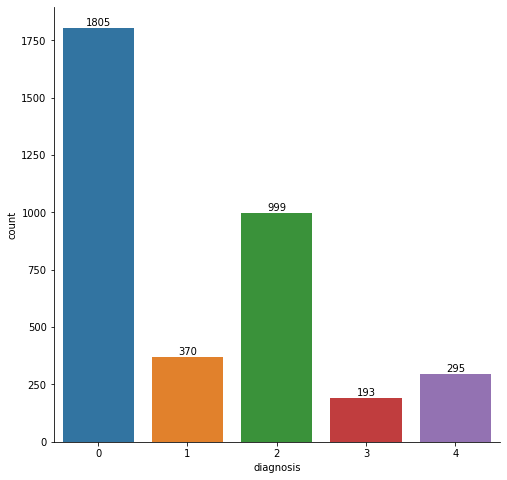

In [4]:
# Visualizing the dataset
print('Number of train samples: ', train.shape[0])
print(train.head())

f, ax = plt.subplots(figsize=(8, 8))
ax = sns.countplot(x="diagnosis", data=train)
ax.bar_label(ax.containers[0])
sns.despine()
plt.show()

In [ ]:
# Setting the model parameters
batch_size = 10
epochs = 30
initial_epochs = 3
LR = 0.0001
initial_LR = 0.001
h = 700
w = 700
channels = 3
TOTAL_CLASSES = train['diagnosis'].nunique()
Early_Stopping_PATIENCE = 5
Reduce_LR_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
# Mapping the images stored in the folder to the CSV file
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
train.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
# Loading the train and validation dataset
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 validation_split=0.2,
                                 rotation_range = 30,
                                 width_shift_range = 0.2,
                                 zoom_range = 0.2,
                                 shear_range = 0.2,
                                 horizontal_flip=True)


train_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                  directory="/content/drive/MyDrive/Diabetic Retinopathy/APTOS 2019/train/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  target_size=(h, w),
                                                  subset='training')

valid_generator=train_datagen.flow_from_dataframe(dataframe=train,
                                                  directory="/content/drive/MyDrive/Diabetic Retinopathy/APTOS 2019/train/",
                                                  x_col="id_code",
                                                  y_col="diagnosis",
                                                  batch_size=batch_size,
                                                  class_mode="categorical",    
                                                  target_size=(h, w),
                                                  subset='validation')

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [ ]:
# Create the fully connected of the Keras pre-trained model
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = Xception(weights='imagenet', 
                          include_top=False,
                          input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)  
    return model

model = create_model(input_shape=(h, w, channels), n_out=TOTAL_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

for l in model.layers:
    print(l.name, l.trainable)

83697664/83683744 [==============================] - 2s 0us/step
input_1 False
block1_conv1 False
block1_conv1_bn False
block1_conv1_act False
block1_conv2 False
block1_conv2_bn False
block1_conv2_act False
block2_sepconv1 False
block2_sepconv1_bn False
block2_sepconv2_act False
block2_sepconv2 False
block2_sepconv2_bn False
conv2d False
block2_pool False
batch_normalization False
add False
block3_sepconv1_act False
block3_sepconv1 False
block3_sepconv1_bn False
block3_sepconv2_act False
block3_sepconv2 False
block3_sepconv2_bn False
conv2d_1 False
block3_pool False
batch_normalization_1 False
add_1 False
block4_sepconv1_act False
block4_sepconv1 False
block4_sepconv1_bn False
block4_sepconv2_act False
block4_sepconv2 False
block4_sepconv2_bn False
conv2d_2 False
block4_pool False
batch_normalization_2 False
add_2 False
block5_sepconv1_act False
block5_sepconv1 False
block5_sepconv1_bn False
block5_sepconv2_act False
block5_sepconv2 False
block5_sepconv2_bn False
block5_sepconv3_act Fa

In [ ]:
# Defining the metrics and parameters
optimizer = optimizers.Adam(lr=initial_LR)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700, 700, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 349, 349, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 349, 349, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 349, 349, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
STEPS_PER_EPOCH_TRAIN = train_generator.n//train_generator.batch_size
STEPS_PER_EPOCH_VALID = valid_generator.n//valid_generator.batch_size

# Training the model with frozen convolutional layers
initial = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEPS_PER_EPOCH_TRAIN,
                              validation_data = valid_generator,
                              validation_steps = STEPS_PER_EPOCH_VALID,
                              epochs = initial_epochs,
                              verbose = 1).history

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/3
293/293 [==============================] - 3028s 10s/step - loss: 1.0111 - accuracy: 0.6682 - val_loss: 0.6783 - val_accuracy: 0.7425
Epoch 2/3
293/293 [==============================] - 434s 1s/step - loss: 0.7634 - accuracy: 0.7103 - val_loss: 0.7091 - val_accuracy: 0.7397
Epoch 3/3
293/293 [==============================] - 427s 1s/step - loss: 0.7278 - accuracy: 0.7258 - val_loss: 0.7597 - val_accuracy: 0.6863


In [ ]:
for layer in model.layers:
    layer.trainable = True

# Defining the metrics to stop model from overfitting 
ES = EarlyStopping(monitor = 'val_loss', mode = 'min', 
                   patience = Early_Stopping_PATIENCE, 
                   restore_best_weights = True, verbose=1)

RLROP = ReduceLROnPlateau(monitor = 'val_accuracy', mode = 'min', 
                          patience = Reduce_LR_PATIENCE, 
                          factor = DECAY_DROP, min_lr = 0.000000001, verbose=1)

# Defining the model parameters
callback_list = [ES, RLROP]
optimizer = optimizers.Adam(lr = LR)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 700, 700, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 349, 349, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 349, 349, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 349, 349, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Training the model
finetune = model.fit_generator(generator=train_generator,
                               steps_per_epoch=STEPS_PER_EPOCH_TRAIN,
                               validation_data=valid_generator,
                               validation_steps=STEPS_PER_EPOCH_VALID,
                               epochs=epochs,
                               callbacks=callback_list,
                               verbose=1).history

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
293/293 [==============================] - 535s 2s/step - loss: 0.3140 - accuracy: 0.6965 - val_loss: 0.2032 - val_accuracy: 0.7890
Epoch 2/30
293/293 [==============================] - 523s 2s/step - loss: 0.2062 - accuracy: 0.7863 - val_loss: 0.1857 - val_accuracy: 0.8151
Epoch 3/30
293/293 [==============================] - 520s 2s/step - loss: 0.1599 - accuracy: 0.8230 - val_loss: 0.1934 - val_accuracy: 0.7918
Epoch 4/30
293/293 [==============================] - 522s 2s/step - loss: 0.1631 - accuracy: 0.8276 - val_loss: 0.1754 - val_accuracy: 0.8219

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/30
293/293 [==============================] - 522s 2s/step - loss: 0.1320 - accuracy: 0.8500 - val_loss: 0.1747 - val_accuracy: 0.8178
Epoch 6/30
293/293 [==============================] - 521s 2s/step - loss: 0.1229 - accuracy: 0.8740 - val_loss: 0.1728 - val_accuracy: 0.8247
Epoch 7/30
293/293 [==============================] - 523s 2s

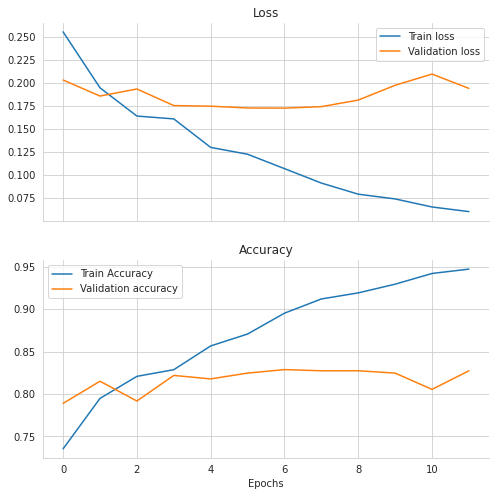

In [ ]:
sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(8, 8))

ax1.plot(finetune['loss'], label='Train loss')
ax1.plot(finetune['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(finetune['accuracy'], label='Train Accuracy')
ax2.plot(finetune['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# Saving the weights file                                          
model.save('/content/drive/MyDrive/Diabetic Retinopathy/APTOS 2019/Models/Xception.h5') 

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
